## Dependencies

In [1]:
import time
start = time.time()
start_CPU = time.process_time()

In [2]:
import pandas as pd
import numpy as np
import statistics as st
from deimosFunction import deimos
from Kennard_Stone import kenStone
from core_function import deimos_core
from deimos_test import deimos_1D_test
from clustering_function import clust
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from validation import q2ext
import multiprocessing as mp
import matplotlib.pyplot as plt

#!pip install mip
#from mip import Model, xsum, minimize, BINARY

In [3]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


## Import dataset

In [4]:
data_file = "C:/Users/Dimitra/data.csv"
data = pd.read_csv(data_file, header=0, sep=";", index_col=0)

X = data.iloc[:, 1:len(data.columns)]
y = data.iloc[:, 0]

# Scaling
X_scaled = (X - X.min()) / (X.max() - X.min())
y_scaled = (y - y.min()) / (y.max() - y.min())

# Splitting into train-test
#from sklearn.model_selection import train_test_split # in case of random splitting
#X_train,X_test,y_train,y_test=train_test_split(X_scaled, y_scaled, train_size=0.66, random_state=8867453315) #Random

# Kennard-Stone
X_train, X_test, y_train, y_test = kenStone(X_scaled, y_scaled, train_ratio=0.66)

samples_train = y_train.count()  # number of train samples
samples_test = y_test.count() # number of test samples
features = len(X_train.columns)

## Simple linear regression for one region

In [5]:
# Linear regression (R=1)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)

coeffLR = lr.coef_
interceptLR = lr.intercept_

predictionsLR = pd.DataFrame(lr.predict(X_test), index=X_test.index, columns=['Prediction'])
y_hat_lr = lr.predict(X_train)
RMSE_lr = sqrt(mean_squared_error(y_train, y_hat_lr))
r_lr = np.corrcoef(y_train, y_hat_lr)
R2lr = r_lr[0][1]**2

y_hat_test_lr = pd.DataFrame(lr.predict(X_test), index=X_test.index, columns=['Prediction'])
RMSE_test_lr = sqrt(mean_squared_error(y_test, y_hat_test_lr))
q2lr = q2ext(y_test, predictionsLR, y_train)
print("RMSE linear regression", RMSE_lr)
print("R2 linear regression", R2lr)
print("RMSE test linear regression", RMSE_test_lr)
print("q2 external linear regression", q2lr)

RMSE linear regression 4.1333278702563594e-16
R2 linear regression 1.0
RMSE test linear regression 0.1303948801389817
q2 external linear regression 0.4424201278542842


## Lasso

In [6]:
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)
train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)
opt_alpha = lasso.alpha_

coeff = lasso.coef_
intercept_lasso = lasso.intercept_
coeff_used = np.sum(lasso.coef_ != 0)

#train
y_hat_lasso = lasso.predict(X_train)
RMSE_lasso = sqrt(mean_squared_error(y_train, y_hat_lasso))
r_lasso = np.corrcoef(y_train, y_hat_lasso)
R2_lasso = r_lasso[0][1]**2

# test
predictions = pd.DataFrame(lasso.predict(X_test), index=X_test.index, columns=['Prediction'])
q2_lasso = q2ext(y_test, predictions, y_train)
RMSE_test_lasso = sqrt(mean_squared_error(y_test, predictions))

print("optimum alpha: ", opt_alpha)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)
print("RMSE lasso", RMSE_lasso)
print("R2 lasso", R2_lasso)
print("RMSE test lasso", RMSE_test_lasso)
print("q2 external lasso", q2_lasso)

optimum alpha:  0.005533069651677502
training score: 0.8300574644626307
test score:  0.7187422681116893
number of features used:  8
RMSE lasso 0.10265117837449741
R2 lasso 0.8485462407667924
RMSE test lasso 0.09039558314125638
q2 external lasso 0.7320335452528778


## Select primary comprative model

In [8]:
# lasso
if RMSE_test_lasso <= RMSE_test_lr:
    selected_base_model = "lasso"
    base_model = lasso
    optRMSE_test = RMSE_test_lasso
    MAE_in_test = st.mean(abs(predictions.squeeze() - y_test))
    REG_in = sum(abs(lasso.coef_))
    selected_variables = coeff
    intercept_base = intercept_lasso
    R2_base = R2_lasso
    RMSE_base = RMSE_lasso
    q2_base = q2_lasso
    RMSE_test_base = RMSE_test_lasso
    y_hat_base = y_hat_lasso
    y_hat_test_base = lasso.predict(X_test)
# MLR
else:
    selected_base_model = "MLR"
    base_model = lr
    optRMSE_test = RMSE_test_lr
    MAE_in_test = st.mean(abs(predictionsLR.squeeze() - y_test))
    REG_in = sum(abs(coeffLR))
    selected_variables = coeffLR
    intercept_base = interceptLR
    R2_base = R2lr
    RMSE_base = RMSE_lr
    q2_base = q2lr
    RMSE_test_base = RMSE_test_lr
    y_hat_base = y_hat_lr
    y_hat_test_base = lr.predict(X_test)

In [9]:
selected_base_model

'lasso'

## Main deimos

In [10]:
%%time
# parameters
lREG_min = 0.001
lREG_max = 0.07 
step = 0.001
U = 10
U2 = abs(sum(y_test))
beta = 0.05
epsilon = 0.05

start_parall = time.process_time()

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `deimos_regions()`
results = [pool.apply(deimos_regions, args = (lREG, MAE_in_test, REG_in, epsilon, beta, U, U2, features, samples_train, X_train, y_train, X_test, y_test, y_hat_base, y_hat_test_base)) for lREG in np.arange(lREG_min, lREG_max, step)]

# Step 3: Close
pool.close() 

end_parall = time.process_time()

print("Execution CPU time [s]:", (end_parall-start_parall))

Execution CPU time [s]: 0.234375
Wall time: 7min 29s


## Optimal solution

In [11]:
optFound = 0

# save results from each lREG
finalregions_lREG = []
bestYr_lREG = []
bestWrf_lREG = []
bestBr_lREG = []
bestFrs_lREG = []
bestREG_lREG = []
bestMAE_lREG = []
bestPred_lREG = []
bestEs_lREG = []
y_hat_lREG = []
best_z_lREG = []
best_correctly_assigned_lREG = []
bestPs_test_lREG = []
RMSE_test_lREG = []
y_hat_test_lREG = []
test_idx_lREG = []
bestcentroids_lREG = []
bestvar_lREG = []

for i in range(len(results)):
    finalregions_lREG.append(results[i][0])
    bestYr_lREG.append(results[i][1])
    bestWrf_lREG.append(results[i][2])
    bestBr_lREG.append(results[i][3])
    bestFrs_lREG.append(results[i][4])
    bestREG_lREG.append(results[i][5])
    bestMAE_lREG.append(results[i][6])
    bestPred_lREG.append(results[i][7])
    bestEs_lREG.append(results[i][8])
    y_hat_lREG.append(results[i][9])
    best_z_lREG.append(results[i][10])
    best_correctly_assigned_lREG.append(results[i][11])
    bestPs_test_lREG.append(results[i][12])
    RMSE_test_lREG.append(results[i][13])
    y_hat_test_lREG.append(results[i][14])
    test_idx_lREG.append(results[i][15])
    bestcentroids_lREG.append(results[i][16])
    bestvar_lREG.append(results[i][17])

for i in range(len(finalregions_lREG)):
    if finalregions_lREG[i] >= 2:
        possible_opt = RMSE_test_lREG[i]
        if possible_opt <= optRMSE_test:
            optFound = 1  # Optimal grouping in regions found
            optRMSE_test = possible_opt
            opt_position = RMSE_test_lREG.index(possible_opt)
            optlREG = lREG_min + opt_position * step
            optregions = finalregions_lREG[opt_position]
            optcentroids = bestcentroids_lREG[opt_position]
            opt_common_variables = bestvar_lREG[opt_position]

            optYr = bestYr_lREG[opt_position]
            optWrf = bestWrf_lREG[opt_position]
            optBr = bestBr_lREG[opt_position]
            optFrs = bestFrs_lREG[opt_position]
            optREG = bestREG_lREG[opt_position]
            optMAE = bestMAE_lREG[opt_position]
            optPred = bestPred_lREG[opt_position]
            optz = best_z_lREG[opt_position]
            optEs = bestEs_lREG[opt_position]
            opt_y_hat = y_hat_lREG[opt_position]
            opt_correctly_assigned = best_correctly_assigned_lREG[opt_position]

            optPs_test = bestPs_test_lREG[opt_position]
            opt_y_hat_test = y_hat_test_lREG[opt_position]
            optTest_idx = test_idx_lREG[opt_position]
            optPs_test = bestPs_test_lREG[opt_position]       

In [13]:
if optFound == 1:        
    # Training statistics
    # R2 & RMSE in regions
    optR2_re = []
    optRMSE_re = []
    y_train_re = []
    Ps = pd.DataFrame(optPred)*pd.DataFrame(optFrs)
    for re in range(optregions):
        if sum(optFrs[re]) <= 1:
            optR2_re.append(np.nan)
            optRMSE_re.append(np.nan)
        else:
            flag = pd.DataFrame(optFrs).iloc[re,] == 1
            pos = np.flatnonzero(flag)  # position of samples
            y_train_re.append(y_train.iloc[pos])
            y_hat_re = Ps.iloc[re].iloc[pos]
            r_re = np.corrcoef(y_train_re[re], y_hat_re)
            optR2_re.append(r_re[0][1] ** 2)
            optRMSE_re.append(sqrt(mean_squared_error(y_train_re[re], y_hat_re)))
            del y_hat_re, r_re
                
    # R2 training
    r = np.corrcoef(y_train, opt_y_hat)
    optR2 = r[0][1]**2

    # RMSE
    optRMSE = sqrt(mean_squared_error(y_train, opt_y_hat))
        
    #Test statistics
    # q2 test
    optq2 = q2ext(y_test, opt_y_hat_test, y_train)
        
    # q2 & RMSE in regions
    optq2_re = []
    optRMSE_re = []
    for re in range(optregions):
        if sum(optTest_idx[re]) < 1:
            optq2_re.append(np.nan)
            optRMSE_re.append(np.nan)
        else:
            flag = pd.DataFrame(optTest_idx).iloc[re,] == 1
            pos = np.flatnonzero(flag)  # position of samples
            y_test_re = y_test.iloc[pos]
            y_test_hat_re = optPs_test.iloc[re].iloc[pos]
            y_train_re = y_train.iloc[pos]
            optq2_re.append(q2ext(y_test_re, y_test_hat_re, y_train_re))
            optRMSE_re.append(sqrt(mean_squared_error(y_test_re, y_test_hat_re)))
            del y_test_re, y_test_hat_re   
        

## Selected variables

In [14]:
if optFound == 1:
    group_train = []
    for i in range(samples_train):
        for re in range(optregions):
            if optFrs[re][i] == 1:
                group_train.append(("region"+str(re)))

    group_test = []
    for i in range(samples_test):
        for re in range(optregions):
            if optTest_idx[re][i] == 1:
                group_test.append(("region"+str(re)))

    group_train = pd.DataFrame(group_train, index = X_train.index)
    group_test = pd.DataFrame(group_test, index = X_test.index)
    
else:
    print("No optimal solution found-no possible grouping")

In [15]:
total_selected = []
if optFound == 1:
    selINregion = []
    for re in range(optregions):
        selected = X.columns[[optWrf[re][i]>0 for i in range(len(optWrf[1]))]]
        print("Variables in region", re, selected)
        selINregion.append(len(selected))
        for i in selected:
            if i not in total_selected:
                total_selected.append(i)
    print('# variables per region', selINregion)
    print('total variables', len(total_selected))
else:
    selected =  X.columns[[selected_variables[i]!=0 for i in range(len(selected_variables))]]
    for i in selected:
        if i not in total_selected:
            total_selected.append(i)
    print('total variables', len(total_selected))
    print("Variables", selected)

Variables in region 0 Index(['lspri_serum', 'zav_synth', 'zav_serum', 'vol_synth', 'zp_synth_sign',
       'P02649', 'P0C0L5', 'P10720', 'P02749', 'P02654', 'Q13103', 'P00748',
       'P00740', 'P03950', 'P09871', 'P27169', 'P20851', 'P08567', 'P00451',
       'Q99467'],
      dtype='object')
Variables in region 1 Index(['lspri_serum', 'vol_synth', 'int_serum', 'zav_rel', 'P01009', 'P00738',
       'P01011', 'P00736', 'P01019', 'P02671', 'Q99467'],
      dtype='object')
# variables per region [20, 11]
total variables 28


## Samples in regions

In [16]:
if optFound == 1:
    trainINregions = []
    testINregions = []
    for re in range(optregions):
        trainINregions.append(len(X_train.index[(np.where(optFrs[re]))]))
        testINregions.append(len(X_test.index[(np.where(optTest_idx[re]))]))
        
    print('train samples per region', trainINregions)
    print('test samples per region', testINregions)

train samples per region [43, 12]
test samples per region [25, 4]


## Train statistics

In [17]:
if optFound == 1:
    print("lambda optimal: ", optlREG)
    print("Correctly assigned training samples in clusterig", sum(opt_correctly_assigned.iloc[0]), "out of", samples_train)
    print("train-RMSE optimal: ", optRMSE)
    print("train-RMSE optimal per region: ", optRMSE_re)
    print("R2 optimal: ", optR2)
    print("R2 optimal per region: ", optR2_re)
else:
    print("Results for one region ", selected_base_model)
    print("train-RMSE: ", RMSE_base)
    print("R2: ", R2_base)

lambda optimal:  0.001
Correctly assigned training samples in clusterig 52 out of 55
train-RMSE optimal:  0.06234027448512108
train-RMSE optimal per region:  [0.07526368131255784, 0.0382700005833685]
R2 optimal:  0.9387487973590238
R2 optimal per region:  [0.7550302968778426, 1.0]


In [18]:
if optFound == 1:
    print("samples in regions")
    for re in range(optregions):
        print("region", re)
        print(X_train.index[(np.where(optFrs[re]))])

samples in regions
region 0
Index(['G15.NT@DCA', 'G60.DTNB', 'G15.CTAB', 'G30.TP', 'G15.DDT@ODA', 'G15.LA',
       'G60.PVA', 'G60.CIT', 'G15.AC', 'G15.NT@PSMA-EDA', 'G15.MES',
       'G60.DDT@BDHDA', 'G15.DDT@SDS', 'G60.MBA', 'G15.CALNN', 'G15.T20',
       'G15.SA', 'G15.DDT@BDHDA', 'G60.CVVIT', 'G15.DDT@SA', 'G60.CTAB',
       'G30.Thr-SH', 'G15.MSA', 'G15.SPP', 'G15.PVP', 'G60.ODA', 'G30.MAA',
       'G15.DTNB', 'G15.DDT@CTAB', 'G15.Gly-SH', 'G30.CFGAILS', 'G30.LA',
       'G15.ODA', 'G15.TP', 'G30.MUA', 'G15.MHDA', 'G60.NT@PSMA-AP',
       'G30.DDT@BDHDA', 'G15.F127', 'G30.DDT@CTAB', 'G60.Trp-SH', 'G15.PVA',
       'G15.Met-SH'],
      dtype='object', name='ENM')
region 1
Index(['G15.MUTA', 'G60.AUT', 'G60.MUTA', 'G15.PAH-SH', 'G15.PLL-SH',
       'G15.HDA', 'G15.AHT', 'G30.DDT@DOTAP', 'G30.PAH-SH', 'G60.DDT@DOTAP',
       'G15.DDT@DOTAP', 'G30.MUTA'],
      dtype='object', name='ENM')


## Test statistics

In [19]:
if optFound == 1:
    r_test = np.corrcoef(y_test, opt_y_hat_test)
    r2_test = r_test[0][1]**2
    print("test-RMSE optimal: ", optRMSE_test)
    print("test-RMSE per region: ", optRMSE_re)
    print("q2 optimal: ", optq2)
    print("q2 per region: ", optq2_re)
    print("r2 test: ", r2_test)
    
else:
    r_test = np.corrcoef(y_test, y_hat_test_base)
    r2_test = r_test[0][1]**2
    print("Results for one region ", selected_base_model)
    print("test-RMSE: ", RMSE_test_base)
    print("q2: ", q2_base)
    print("r2 test: ", r2_test)

test-RMSE optimal:  0.07131134138568868
test-RMSE per region:  [0.07526368131255784, 0.0382700005833685]
q2 optimal:  0.8332356479254565
q2 per region:  [0.7553181551120335, 0.9934610786589052]


In [20]:
if optFound == 1:
    column_2_train = pd.DataFrame(np.array(opt_y_hat), index=X_train.index, columns=['Prediction'])
else:
    column_2_train = pd.DataFrame(y_hat_base, index=X_train.index, columns=['Prediction'])

pd.concat([y_train, column_2_train], axis = 1)

,net.c,Prediction
ENM,,
G15.MUTA,0.877500,0.877500
G15.NT@DCA,0.000000,0.162830
G60.DTNB,0.273913,0.349582
G15.CTAB,0.274847,0.274847
G30.TP,0.448303,0.448303
G15.DDT@ODA,0.248672,0.248672
G60.AUT,0.787473,0.787473
G15.LA,0.264590,0.264590
G60.PVA,0.321332,0.274560


In [21]:
# final predictions table
if optFound == 1:
    column_2 = pd.DataFrame(np.array(opt_y_hat_test), index=X_test.index, columns=['Prediction'])
    print("samples in regions")
    for re in range(optregions):
        print("region", re)
        print(X_test.index[(np.where(optTest_idx[re]))])
else:
    column_2 = pd.DataFrame(y_hat_test_base, index=X_test.index, columns=['Prediction'])
    
final_table = pd.concat([y_test, column_2], axis=1)
print(final_table)

samples in regions
region 0
Index(['G15.Ala-SH', 'G15.Asn-SH', 'G15.CIT', 'G15.MAA', 'G15.MBA', 'G15.MHA',
       'G15.MPA', 'G15.MUA', 'G15.NT@PSMA-AAP', 'G15.NT@PSMA-EA',
       'G15.NT@PSMA-Urea', 'G15.Phe', 'G15.Phe-SH', 'G15.Ser-SH', 'G15.Thr-SH',
       'G15.Trp-SH', 'G30.AC', 'G30.CALNN', 'G30.DDT@HDA', 'G30.Met-SH',
       'G30.MHDA', 'G60.MPA', 'G60.Phe-SH', 'G60.Ser-SH', 'G60.SPP'],
      dtype='object', name='ENM')
region 1
Index(['G15.AUT', 'G15.PEI-SH', 'G30.AUT', 'G60.HDA'], dtype='object', name='ENM')
                     net.c  Prediction
ENM                                   
G15.Ala-SH        0.310945    0.269360
G15.Asn-SH        0.293567    0.236114
G15.AUT           0.733427    0.736450
G15.CIT           0.319475    0.262639
G15.MAA           0.246631    0.303506
G15.MBA           0.323348    0.398292
G15.MHA           0.287642    0.363402
G15.MPA           0.321884    0.418256
G15.MUA           0.377266    0.399295
G15.NT@PSMA-AAP   0.238386    0.255578
G15.NT@PSM

In [22]:
# final predictions table (real values, not normalized)
y_test_real = y_test*(y.max() - y.min())+y.min()
y_train_real = y_train*(y.max() - y.min())+y.min()
if optFound == 1:
    opt_y_hat_test_real = opt_y_hat_test*(y.max() - y.min())+y.min()
    column_2_real = pd.DataFrame(np.array(opt_y_hat_test_real), index=X_test.index, columns=['Prediction'])
    q2_real = q2ext(y_test_real, opt_y_hat_test_real, y_train_real)
else:
    y_hat_test_base_real = y_hat_test_base*(y.max() - y.min())+y.min()
    column_2_real = pd.DataFrame(y_hat_test_base_real, index=X_test.index, columns=['Prediction'])
    q2_real = q2ext(y_test_real, y_hat_test_base_real, y_train_real)
    
    
final_table = pd.concat([y_test_real, column_2_real], axis=1)
print(final_table)
print("q2 real", q2_real)

                     net.c  Prediction
ENM                                   
G15.Ala-SH       -5.504387   -5.916686
G15.Asn-SH       -5.676688   -6.246302
G15.AUT          -1.315666   -1.285697
G15.CIT          -5.419816   -5.983322
G15.MAA          -6.142035   -5.578141
G15.MBA          -5.381423   -4.638377
G15.MHA          -5.735428   -4.984304
G15.MPA          -5.395929   -4.440442
G15.MUA          -4.846843   -4.628438
G15.NT@PSMA-AAP  -6.223778   -6.053329
G15.NT@PSMA-EA   -6.167734   -6.288266
G15.NT@PSMA-Urea -6.360527   -5.845502
G15.PEI-SH       -1.292157   -1.121939
G15.Phe          -5.303579   -6.014166
G15.Phe-SH       -6.268678   -6.386052
G15.Ser-SH       -5.224317   -5.712929
G15.Thr-SH       -5.859771   -6.517740
G15.Trp-SH       -6.965784   -6.532824
G30.AC           -3.435963   -5.076738
G30.AUT          -1.630796   -1.227786
G30.CALNN        -7.551649   -7.070322
G30.DDT@HDA      -5.308716   -3.933557
G30.Met-SH       -5.228638   -5.688143
G30.MHDA         -4.32597

In [23]:
if optFound == 1:
    print("optYr", optYr)
    print("--------------------------------")

    for re in range(optregions):
        print("region", re)
        print("samples", np.where(optTest_idx[re]))
        print("y_test", y_test.iloc[np.where(optTest_idx[re])])
        print("--------------------------------")


optYr [0.644890351708483, 1.0]
--------------------------------
region 0
samples (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 25, 26, 27, 28], dtype=int64),)
y_test ENM
G15.Ala-SH          0.310945
G15.Asn-SH          0.293567
G15.CIT             0.319475
G15.MAA             0.246631
G15.MBA             0.323348
G15.MHA             0.287642
G15.MPA             0.321884
G15.MUA             0.377266
G15.NT@PSMA-AAP     0.238386
G15.NT@PSMA-EA      0.244039
G15.NT@PSMA-Urea    0.224593
G15.Phe             0.331199
G15.Phe-SH          0.233857
G15.Ser-SH          0.339193
G15.Thr-SH          0.275101
G15.Trp-SH          0.163546
G30.AC              0.519570
G30.CALNN           0.104455
G30.DDT@HDA         0.330681
G30.Met-SH          0.338758
G30.MHDA            0.429802
G60.MPA             0.555526
G60.Phe-SH          0.447968
G60.Ser-SH          0.458572
G60.SPP             0.419211
Name: net.c, dtype: float64
------------------------

## Model

In [24]:
if optFound == 1:
    print("regions: ", optregions)
    print("centroids", optcentroids)
    print("coefficients", optWrf)
    print("intercept: ", optBr)
else:
    print("final model: ", selected_base_model)
    print("coefficients: ",selected_variables)
    print("intercept: ", intercept_base)

regions:  2
centroids [lspri_serum      0.247866
zav_synth        0.155074
zav_serum        0.306897
vol_synth        0.145799
int_serum        0.348017
zav_rel          0.317650
zp_synth_sign    0.186047
P02649           0.215444
P01009           0.138661
P0C0L5           0.190114
P10720           0.280140
P02749           0.177930
P02654           0.112784
P00738           0.085283
P01011           0.107706
Q13103           0.059842
P00736           0.107716
P00748           0.118323
P00740           0.092603
P03950           0.204139
P09871           0.077301
P27169           0.094216
P20851           0.100057
P08567           0.062613
P01019           0.032406
P02671           0.104576
P00451           0.067563
Q99467           0.015892
dtype: float64, lspri_serum      0.474539
zav_synth        0.155024
zav_serum        0.557149
vol_synth        0.148191
int_serum        0.582510
zav_rel          0.390045
zp_synth_sign    1.000000
P02649           0.042399
P01009           0.514515

## Plots

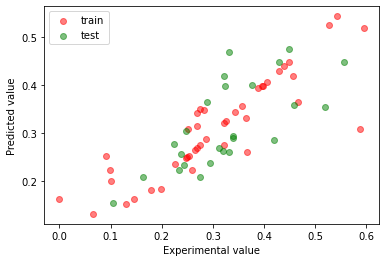

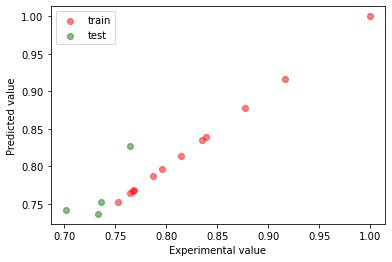

In [25]:
if optFound == 1:
    for re in range(optregions):
        plt.scatter(y_train.iloc[np.where(optFrs[re])], opt_y_hat[np.where(optFrs[re])], c="r", alpha=0.5, label="train")
        plt.scatter(y_test.iloc[np.where(optTest_idx[re])], opt_y_hat_test.iloc[np.where(optTest_idx[re])], c="g", alpha=0.5, label="test")
        plt.xlabel("Experimental value")
        plt.ylabel("Predicted value")
        plt.legend(loc='upper left')
        plt.show()
else:
    plt.scatter(y_train, y_hat_base, c="r", alpha=0.5, label="train")
    plt.scatter(y_test, y_hat_test_base, c="g", alpha=0.5, label="test")
    plt.xlabel("Experimental value")
    plt.ylabel("Predicted value")
    plt.legend(loc='upper left')
    plt.show()

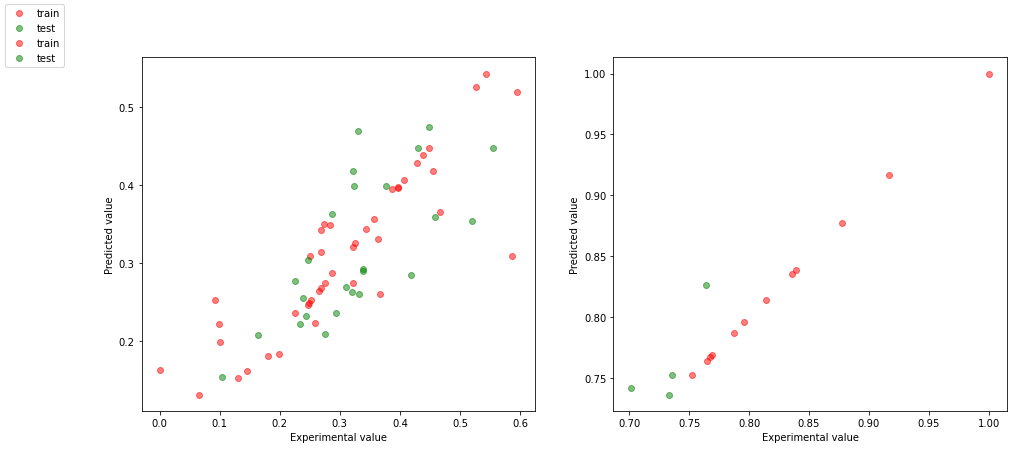

In [26]:
if optFound == 1:
    fig, axs = plt.subplots(1, optregions)
    for re in range(optregions):
            axs[re].scatter(y_train.iloc[np.where(optFrs[re])], opt_y_hat[np.where(optFrs[re])], c="r", alpha=0.5,
                            label="train")
            axs[re].scatter(y_test.iloc[np.where(optTest_idx[re])], opt_y_hat_test.iloc[np.where(optTest_idx[re])],
                            c="g", alpha=0.5, label="test")
            axs[re].set(xlabel="Experimental value", ylabel="Predicted value")
    fig.legend(loc='upper left')
    fig.set_size_inches(15.5, 6.5, forward=True)
    fig.savefig('finalplot.svg')
else:
    fig = plt.subplot()
    fig.scatter(y_train, y_hat_base, c="r", alpha=0.5, label="train")
    fig.scatter(y_test, y_hat_test_base, c="g", alpha=0.5, label="test")
    fig.set(xlabel="Experimental value", ylabel="Predicted value")
    fig.legend(loc='upper left')
    fig.set_size_inches(15.5, 6.5, forward=True)
    plt.savefig('finalplot.svg')

In [28]:
end = time.time()

print("Execution (wall) time [min]:", (end-start)/60)

Execution (wall) time [min]: 7.630289097627004


In [29]:
end_CPU = time.process_time()

print("Execution CPU time [s]:", (end_CPU-start_CPU))

Execution CPU time [s]: 6.84375


## Use the model

In [30]:
# Read file with untested samples
data_file_untested = "C:/Users/Dimitra/untested.csv"
data_untested = pd.read_csv(data_file_untested, header=0, sep=";", index_col=0)

# Scaling
X_untested_scaled = (data_untested - X.min()) / (X.max() - X.min())

if optFound == 1:
    from deimos_final_model import deimos_1D_model

    y_hat_untested, untested_idx = deimos_1D_model(optcentroids, opt_common_variables, optregions, X_untested_scaled, optWrf, optBr)
    y_hat_untested = pd.DataFrame(np.array(y_hat_untested), index=data_untested.index, columns=['Prediction'])
    
    print("samples in regions")
    for re in range(optregions):
        print("region", re)
        print(data_untested.index[(np.where(untested_idx[re]))])
else:
    y_hat_untested = pd.DataFrame(base_model.predict(X_untested_scaled), index=data_untested.index, columns=['Prediction'])

# Applicability domain
domain = []
for i in range(len(X_untested_scaled)):
    flag = 0
    for j in range(len(X_untested_scaled.columns)):
        if (X_untested_scaled.iloc[1,j]<0) or (X_untested_scaled.iloc[1,j]>1):
            flag = 1
    if flag == 1:
        domain.append("unreliable")
    else:
        domain.append("reliable")

domain = pd.DataFrame(np.array(domain), index=data_untested.index, columns=['Applicability'])

final = pd.concat([y_hat_untested, domain], axis=1)

print(final)

samples in regions
region 0
Index(['G15.AC', 'G15.Ala-SH', 'G15.Asn-SH', 'G15.CALNN'], dtype='object', name='ENM')
region 1
Index(['G15.AHT', 'G15.AUT'], dtype='object', name='ENM')
            Prediction Applicability
ENM                                 
G15.AC        0.343270      reliable
G15.AHT       0.764404      reliable
G15.Ala-SH    0.269360      reliable
G15.Asn-SH    0.236114      reliable
G15.AUT       0.736450      reliable
G15.CALNN     0.160968      reliable
